# EAS503 : Intro to Data Driven Analysis


## Final Project Group 26

---
SUBMITTED BY -
---
| Name | Person ID | Email |
| --- | --- | --- |
| AMAN PRAKASH | 50416755 | amanprak@buffalo.edu |
| Prashant Upadhyay | 50419393 | pupadhya@buffalo.edu |
| Serath Chandra Nutakki | 50363265 | serathch@buffalo.edu |
| Vamshivardhan Reddy Balannagari | 50435533 | vamshiva@buffalo.edu |

> The goal of the notebook is to create multiple features of the audio file from the GTZAN dataset. We are going to use the timbral texture and tempo based features for extraction of information from the audio file. The goal of the dataset is to predict the accuracy of the model. 

## Importing the libraries

In [1]:
import os
import librosa
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import kurtosis
from scipy.stats import skew

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

import lightgbm as lgbm
from IPython.display import Markdown as md

## Set the seed.

In [2]:
np.random.seed(42)

## Directory path to fetch the music dataset

In [3]:
gtzan_dir = '../data/genres/'

## Parameters predefined with song samples and genres

In [4]:
song_samples = 22050*30
genres = {'metal': 0, 'disco': 1, 'classical': 2, 'hiphop': 3, 'jazz': 4, 
          'country': 5, 'pop': 6, 'blues': 7, 'reggae': 8, 'rock': 9}

## Feature Extraction of Music.

In [5]:
def get_features(y, sr, n_fft = 1024, hop_length = 512):
    # Features to concatenate in the final dictionary
    features = {'feature_centroid': None,
                'feature_roloff': None,
                'feature_flux': None,
                'feature_rmse': None,
                'feature_zcr': None,
                'feature_contrast': None,
                'feature_bandwidth': None,
                'feature_flatness': None
               }
    
    # Count silence length of music
    if 0 < len(y):
        y_sound, _ = librosa.effects.trim(y, frame_length=n_fft, hop_length=hop_length)
    features['sample_silence'] = len(y) - len(y_sound)

    # Using the librosa library to extract the features of the music.
    
    #Compute the spectral centroid.
    features['feature_centroid'] = librosa.feature.spectral_centroid(y, sr=sr, n_fft=n_fft, hop_length=hop_length).ravel()
    #Compute root-mean-square (RMS) value for each frame, either from the audio samples y or from a spectrogram S.
    features['feature_rmse'] = librosa.feature.rms(y, frame_length=n_fft, hop_length=hop_length).ravel()
    #Compute the tempogram: local autocorrelation of the onset strength envelope.
    features['feature_flux'] = librosa.onset.onset_strength(y=y, sr=sr).ravel()
    #Compute spectral contrast
    features['feature_contrast'] = librosa.feature.spectral_contrast(y, sr=sr).ravel()
    #Compute roll-off frequency.
    features['feature_roloff'] = librosa.feature.spectral_rolloff(y, sr=sr, n_fft=n_fft, hop_length=hop_length).ravel()
    #Compute the zero-crossing rate of an audio time series.
    features['feature_zcr'] = librosa.feature.zero_crossing_rate(y, frame_length=n_fft, hop_length=hop_length).ravel()
    #Compute p’th-order spectral bandwidth.
    features['feature_bandwidth'] = librosa.feature.spectral_bandwidth(y, sr=sr, n_fft=n_fft, hop_length=hop_length).ravel()
    #Compute spectral flatness
    features['feature_flatness'] = librosa.feature.spectral_flatness(y, n_fft=n_fft, hop_length=hop_length).ravel()


    # MFCC treatment
    mfcc = librosa.feature.mfcc(y, n_fft = n_fft, hop_length = hop_length, n_mfcc=13)
    for i_d, v_mfcc in enumerate(mfcc):
        features['mfcc_{}'.format(i_d)] = v_mfcc.ravel()
        
    # Get statistics from the vectors
    def get_moments(features_description):
        result = {}
        for i, j in features_description.items():
            result['{}_max_value'.format(i)] = np.max(j)
            result['{}_min_value'.format(i)] = np.min(j)
            result['{}_mean_value'.format(i)] = np.mean(j)
            result['{}_std_value'.format(i)] = np.std(j)
            result['{}_kurtosis_value'.format(i)] = kurtosis(j)
            result['{}_skew_value'.format(i)] = skew(j)
        return result
    
    dict_agg_features = get_moments(features)
    dict_agg_features['tempo'] = librosa.beat.tempo(y, sr=sr)[0]
    
    return dict_agg_features

## Read the music clip from the directory and calculating the features of each of the music file.

In [6]:
def read_process_songs(src_dir, debug = True):    
    # Empty array of dicts with the processed features from all files
    arr_features = []

    # Read files from the folders
    for i,_ in genres.items():
        folder = src_dir + i
        
        for root, _dir_, files in os.walk(folder):
            for file in files:
                # Read the audio file
                file_name = folder + "/" + file
                signal, sr = librosa.load(file_name)
                
                # Debug process
                if debug:
                    print("Reading file: {}".format(file_name))
                
                # Append the result to the data structure
                features = get_features(signal, sr)
                features['genre'] = genres[i]
                arr_features.append(features)
    return arr_features

## Calculating and storing all the features in features variable
## Also calculating the time required for the cell to run

In [7]:
%%time

# Get list of dicts with features and convert to dataframe
features = read_process_songs(gtzan_dir, debug=False)

CPU times: user 21min 52s, sys: 4min 55s, total: 26min 47s
Wall time: 3min 39s


## Converting the features into pandas dataframe.

In [8]:
df_features = pd.DataFrame(features)
display(df_features)

,feature_centroid_max_value,feature_centroid_min_value,feature_centroid_mean_value,feature_centroid_std_value,feature_centroid_kurtosis_value,feature_centroid_skew_value,feature_roloff_max_value,feature_roloff_min_value,feature_roloff_mean_value,feature_roloff_std_value,...,mfcc_11_kurtosis_value,mfcc_11_skew_value,mfcc_12_max_value,mfcc_12_min_value,mfcc_12_mean_value,mfcc_12_std_value,mfcc_12_kurtosis_value,mfcc_12_skew_value,tempo,genre
0,3912.471208,1169.002965,2132.025182,324.417877,0.552716,0.280514,8268.750000,2820.849609,4655.068835,532.779319,...,0.202621,0.196498,6.010165,-36.338020,-14.588909,6.630394,-0.046030,-0.079461,135.999178,0
1,4154.095314,1578.173654,2660.278681,431.611019,0.279658,0.333273,7687.353516,3466.845703,5293.454199,765.881429,...,0.194894,-0.135837,12.314498,-37.216621,-13.981811,7.575171,0.086150,0.066093,143.554688,0
2,4800.560724,1354.436266,2226.044634,419.746814,9.683580,2.534200,8031.884766,2562.451172,4717.886501,765.451472,...,0.213038,-0.044061,27.138573,-27.025455,-2.225674,8.439346,0.169127,0.067251,135.999178,0
3,4428.519453,1287.542690,2488.054025,405.421350,1.304210,0.326744,8548.681641,3036.181641,4940.962492,673.794968,...,-0.078183,-0.300594,15.071194,-26.791731,-7.373761,6.288429,-0.121682,-0.080916,143.554688,0
4,3545.496269,1096.964005,2202.509406,350.622300,0.295938,0.201107,7321.289062,2088.720703,5052.259009,576.892904,...,-0.051651,-0.096699,7.234310,-32.025440,-12.785927,5.766219,0.014045,0.036847,112.347147,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,3902.424671,634.116260,1737.928435,660.768219,-0.044963,0.781188,9668.408203,818.261719,3947.653984,1801.648514,...,0.418362,0.197192,27.160713,-14.062637,3.784036,6.099465,0.031450,0.246248,129.199219,9
996,5326.440620,1167.490127,2095.320392,508.194384,7.945724,2.046558,8074.951172,1959.521484,4126.980768,962.940780,...,0.033597,0.114914,19.547951,-38.366940,-8.205006,7.773707,0.312063,-0.275316,129.199219,9
997,4525.487459,1031.742104,2106.824987,586.045723,1.744330,1.097525,8247.216797,1873.388672,4267.138105,1204.391558,...,-0.303408,0.121222,15.901983,-38.125305,-10.124316,7.627946,0.213910,0.093449,99.384014,9
998,4737.446238,1276.203584,2678.575082,552.940574,0.519833,0.845459,8462.548828,2497.851562,5636.612246,1186.557310,...,0.023073,0.105051,20.678095,-23.050922,-1.552439,6.942215,0.054742,0.102711,135.999178,9


## Calculating the shape of the features.

In [9]:
df_features.shape

(1000, 134)

## Storing the dataframe to a csv in the same directory

In [10]:
df_features.to_csv('../data/features.csv', index=False)

## Dropping the feature of genre and making X as indepenedent features set.
## Storing the value of genre in Y and making it as dependent variable.

In [11]:
X = df_features.drop(['genre'], axis=1).values
y = df_features['genre'].values

## Visualization

> Linear (and nonlinear) dimensionality reduction of the GTZAN features for visualization purposes

## Standartize the dataset to fit the transformation.
> Mean as 0 and Standard deviation as 1

In [12]:
scale = StandardScaler()
x_scaled = scale.fit_transform(X)
print(x_scaled)

[[-0.65678368  0.95856545  0.0460748  ... -0.49275612 -0.55170649
   0.71309555]
 [-0.50296481  1.93578829  0.80334491 ... -0.24102004 -0.02606748
   1.07466091]
 [-0.09142238  1.40143603  0.18085502 ... -0.0829896  -0.02188625
   0.71309555]
 ...
 [-0.26653511  0.63074518  0.00994943 ...  0.00229978  0.07272376
  -1.03910579]
 [-0.13160131  1.21459282  0.82957345 ... -0.30083638  0.10616982
   0.71309555]
 [-1.10613418  0.64110751 -0.62712796 ... -0.14847259 -1.56498952
   0.09326923]]


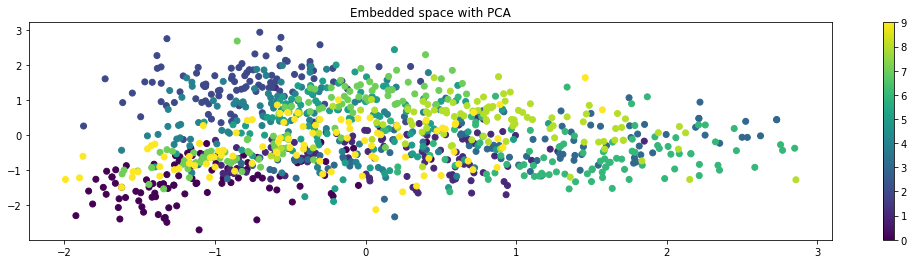



cumulative explained variance ratio = 0.8737


In [13]:
# Use PCA only for visualization
#Principal component analysis (PCA) is a technique for reducing the dimensionality of such datasets,
#increasing interpretability but at the same time minimizing information loss.
pca = PCA(n_components=35, whiten=True)
x_pca = pca.fit_transform(x_scaled)
plt.figure(figsize=(18, 4))
plt.scatter(x_pca[:,0], x_pca[:,1], c=y)
plt.colorbar()
plt.title("Embedded space with PCA")
print("\n")
plt.show()
print("\n")
print("cumulative explained variance ratio = {:.4f}".format(np.sum(pca.explained_variance_ratio_)))

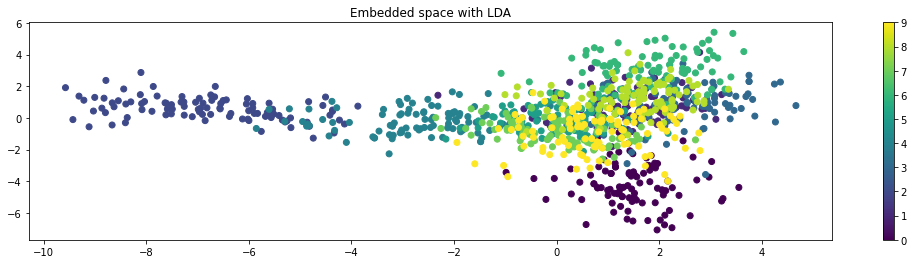

In [14]:
# Use LDA only for visualization
lda = LDA()
x_lda = lda.fit_transform(x_scaled, y)
plt.figure(figsize=(18, 4))
plt.scatter(x_lda[:,0], x_lda[:,1], c=y)
plt.colorbar()
plt.title("Embedded space with LDA")
print("\n")
plt.show()
print("\n")

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.000s...
[t-SNE] Computed neighbors for 1000 samples in 0.026s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 3.258475
[t-SNE] KL divergence after 250 iterations with early exaggeration: 74.584015
[t-SNE] KL divergence after 1000 iterations: 1.043563




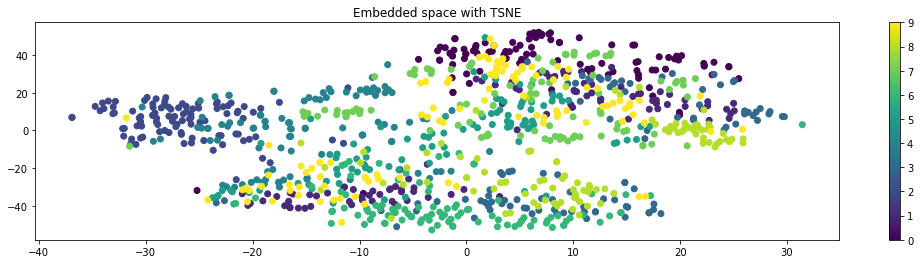

In [15]:
# Using tsne
#tsne is a statistical method for visualizing high-dimensional
#data by giving each datapoint a location in a two or three-dimensional map.
tsne = TSNE(n_components=2, verbose=1, learning_rate=250)
x_tsne = tsne.fit_transform(x_scaled)
plt.figure(figsize=(18, 4))
plt.scatter(x_tsne[:,0], x_tsne[:,1], c=y)
plt.colorbar()
plt.title("Embedded space with TSNE")
print("\n")
plt.show()
print("\n")

## Applying the classical Machine Learning approaches to get the accuracy of the dataset.

## Helper function to plot confusion matrix -- from Scikit-learn website.

In [16]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)
classes = ['metal', 'disco', 'classical', 'hiphop', 'jazz', 'country', 'pop', 'blues', 'reggae', 'rock']

### Logistic Regression

In [18]:
params = {
    "cls__penalty": ["l1", "l2"],
    "cls__C": [0.5, 1, 2, 5],
    "cls__max_iter": [500]
}

pipe_lr = Pipeline([('scale', StandardScaler()),('var_tresh', VarianceThreshold(threshold=(.8 * (1 - .8)))),('feature_selection', SelectFromModel(lgbm.LGBMClassifier())),('cls', LogisticRegression())])
grid_lr = GridSearchCV(pipe_lr, params, scoring='accuracy', n_jobs=6, cv=5)
grid_lr.fit(X_train, y_train)

/Users/prashantupadhyay/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/prashantupadhyay/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/prashantupadhyay/opt/anaconda3/lib/python3.9/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/prashantupadhyay/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/prashantupadhyay/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scale', StandardScaler()),
                                       ('var_tresh',
                                        VarianceThreshold(threshold=0.15999999999999998)),
                                       ('feature_selection',
                                        SelectFromModel(estimator=LGBMClassifier())),
                                       ('cls', LogisticRegression())]),
             n_jobs=6,
             param_grid={'cls__C': [0.5, 1, 2, 5], 'cls__max_iter': [500],
                         'cls__penalty': ['l1', 'l2']},
             scoring='accuracy')


ACCURACY ON TRAIN SET: = 0.7587
ACCURACY ON TEST SET: = 0.7200


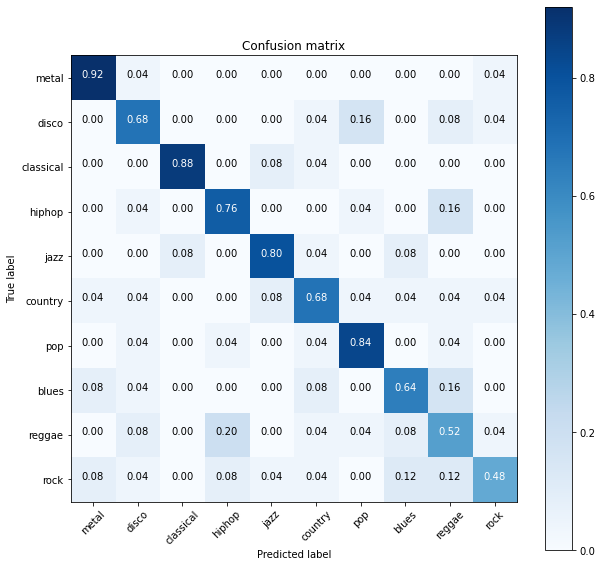

In [19]:
preds = grid_lr.predict(X_test)
alpha_lr = grid_lr.best_score_
beta_lr = accuracy_score(y_test, preds)
print("\nACCURACY ON TRAIN SET: = {:.4f}".format(alpha_lr))
print("ACCURACY ON TEST SET: = {:.4f}".format(beta_lr))

cm = confusion_matrix(y_test, preds)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, classes, normalize=True)

### ElasticNet

In [20]:
params = {
    "cls__loss": ['log'],
    "cls__penalty": ["elasticnet"],
    "cls__l1_ratio": [0.15, 0.25, 0.5, 0.75],
}

pipe_en = Pipeline([
    ('scale', StandardScaler()),
    ('var_tresh', VarianceThreshold(threshold=(.8 * (1 - .8)))),
    ('feature_selection', SelectFromModel(lgbm.LGBMClassifier())),
    ('cls', SGDClassifier())
])

grid_en = GridSearchCV(pipe_en, params, scoring='accuracy', n_jobs=6, cv=5)
grid_en.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scale', StandardScaler()),
                                       ('var_tresh',
                                        VarianceThreshold(threshold=0.15999999999999998)),
                                       ('feature_selection',
                                        SelectFromModel(estimator=LGBMClassifier())),
                                       ('cls', SGDClassifier())]),
             n_jobs=6,
             param_grid={'cls__l1_ratio': [0.15, 0.25, 0.5, 0.75],
                         'cls__loss': ['log'], 'cls__penalty': ['elasticnet']},
             scoring='accuracy')


ACCURACY ON TRAIN SET: = 0.7147
ACCURACY ON TEST SET: = 0.6680


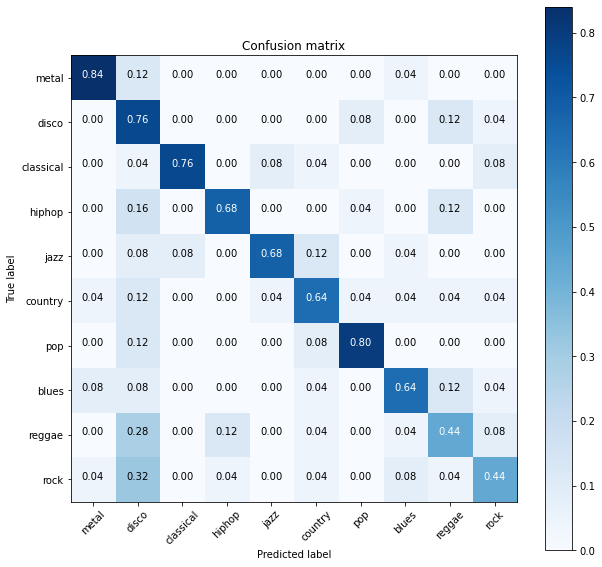

In [21]:
preds = grid_en.predict(X_test)
alpha_en = grid_en.best_score_
beta_en = accuracy_score(y_test, preds)
print("\nACCURACY ON TRAIN SET: = {:.4f}".format(alpha_en))
print("ACCURACY ON TEST SET: = {:.4f}".format(beta_en))

cm = confusion_matrix(y_test, preds)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, classes, normalize=True)

### Decision Tree

In [22]:
params = {
    "cls__criterion": ["gini", "entropy"],
    "cls__splitter": ["best", "random"],
}

pipe_cart = Pipeline([
    ('var_tresh', VarianceThreshold(threshold=(.8 * (1 - .8)))),
    ('feature_selection', SelectFromModel(lgbm.LGBMClassifier())),
    ('cls', DecisionTreeClassifier())
])

grid_cart = GridSearchCV(pipe_cart, params, scoring='accuracy', n_jobs=6, cv=5)
grid_cart.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('var_tresh',
                                        VarianceThreshold(threshold=0.15999999999999998)),
                                       ('feature_selection',
                                        SelectFromModel(estimator=LGBMClassifier())),
                                       ('cls', DecisionTreeClassifier())]),
             n_jobs=6,
             param_grid={'cls__criterion': ['gini', 'entropy'],
                         'cls__splitter': ['best', 'random']},
             scoring='accuracy')


ACCURACY ON TRAIN SET: = 0.5120
ACCURACY ON TEST SET: = 0.5280


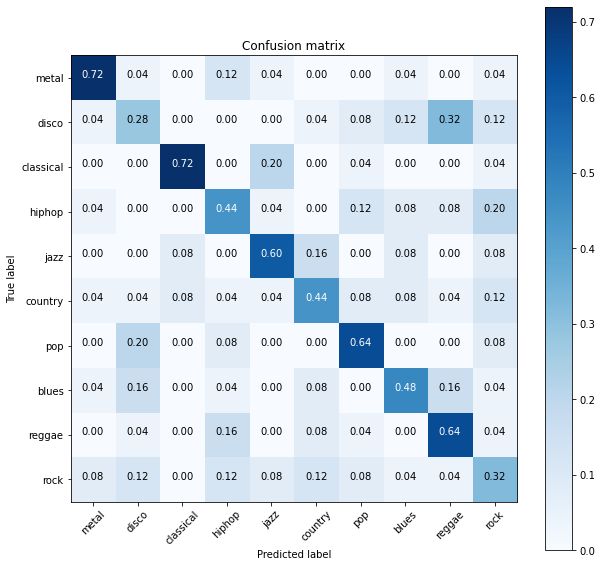

In [23]:
preds = grid_cart.predict(X_test)
alpha_cart = grid_cart.best_score_
beta_cart = accuracy_score(y_test, preds)
print("\nACCURACY ON TRAIN SET: = {:.4f}".format(alpha_cart))
print("ACCURACY ON TEST SET: = {:.4f}".format(beta_cart))

cm = confusion_matrix(y_test, preds)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, classes, normalize=True)

### Random Forest

In [24]:
params = {
    "cls__n_estimators": [100, 250, 500, 1000],
    "cls__criterion": ["gini", "entropy"],
    "cls__max_depth": [5, 7, None]
}

pipe_rf = Pipeline([
    ('var_tresh', VarianceThreshold(threshold=(.8 * (1 - .8)))),
    ('feature_selection', SelectFromModel(lgbm.LGBMClassifier())),
    ('cls', RandomForestClassifier())
])

grid_rf = GridSearchCV(pipe_rf, params, scoring='accuracy', n_jobs=6, cv=5)
grid_rf.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('var_tresh',
                                        VarianceThreshold(threshold=0.15999999999999998)),
                                       ('feature_selection',
                                        SelectFromModel(estimator=LGBMClassifier())),
                                       ('cls', RandomForestClassifier())]),
             n_jobs=6,
             param_grid={'cls__criterion': ['gini', 'entropy'],
                         'cls__max_depth': [5, 7, None],
                         'cls__n_estimators': [100, 250, 500, 1000]},
             scoring='accuracy')


ACCURACY ON TRAIN SET: = 0.7400
ACCURACY ON TEST SET: = 0.6880


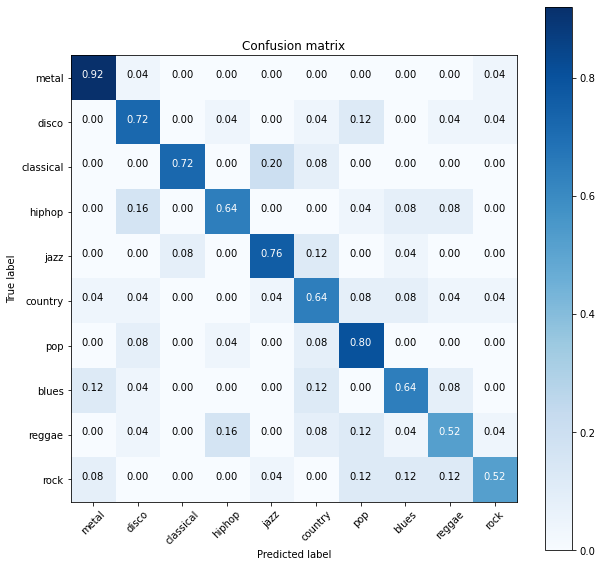

In [25]:
preds = grid_rf.predict(X_test)
alpha_rf = grid_rf.best_score_
beta_rf = accuracy_score(y_test, preds)
print("\nACCURACY ON TRAIN SET: = {:.4f}".format(alpha_rf))
print("ACCURACY ON TEST SET: = {:.4f}".format(beta_rf))

cm = confusion_matrix(y_test, preds)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, classes, normalize=True)

### SVM

In [26]:
params = {
    "cls__C": [0.5, 1, 2, 5],
    "cls__kernel": ['rbf', 'linear', 'sigmoid'],
}

pipe_svm = Pipeline([
    ('scale', StandardScaler()),
    ('var_tresh', VarianceThreshold(threshold=(.8 * (1 - .8)))),
    ('feature_selection', SelectFromModel(lgbm.LGBMClassifier())),
    ('cls', SVC())
])

grid_svm = GridSearchCV(pipe_svm, params, scoring='accuracy', n_jobs=6, cv=5)
grid_svm.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scale', StandardScaler()),
                                       ('var_tresh',
                                        VarianceThreshold(threshold=0.15999999999999998)),
                                       ('feature_selection',
                                        SelectFromModel(estimator=LGBMClassifier())),
                                       ('cls', SVC())]),
             n_jobs=6,
             param_grid={'cls__C': [0.5, 1, 2, 5],
                         'cls__kernel': ['rbf', 'linear', 'sigmoid']},
             scoring='accuracy')


ACCURACY ON TRAIN SET: = 0.7840
ACCURACY ON TEST SET: = 0.7240


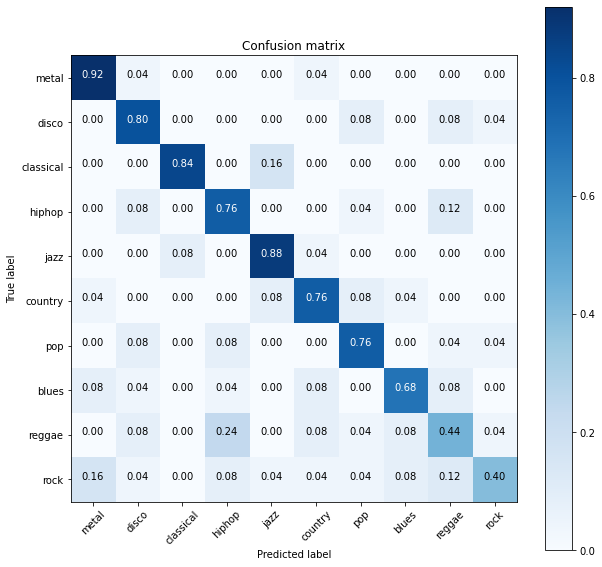

In [27]:
preds = grid_svm.predict(X_test)
alpha_svm = grid_svm.best_score_
beta_svm = accuracy_score(y_test, preds)
print("\nACCURACY ON TRAIN SET: = {:.4f}".format(alpha_svm))
print("ACCURACY ON TEST SET: = {:.4f}".format(beta_svm))

cm = confusion_matrix(y_test, preds)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, classes, normalize=True)

## Results and save the model

In [28]:
import joblib

In [29]:
joblib.dump(grid_svm, "../models/classical_ml.joblib")

['../models/pipe_svm.joblib']

## Model with their train set and test set accuracy in the Markdown.

| MODEL USED | TRAIN SET ACCURACY | TEST SET ACCURACY |
| --- | --- | --- |
| Logistic Regression | {{round(alpha_lr,4)}}| {{round(beta_lr,4)}} |
| ElasticNet | {{round(alpha_en,4)}}| {{round(beta_en,4)}} |
| Decision Tree | {{round(alpha_cart,4)}}| {{round(beta_cart,4)}} |
| Random Forest | {{round(alpha_rf,4)}}| {{round(beta_rf,4)}} |
| Support Vector Machine | {{round(alpha_svm,4)}}| {{round(beta_svm,4)}} |
| ------------------------ | ------------------------ | ------------------------ |
| Average Accuracy | {{round((alpha_lr + alpha_en + alpha_lr + alpha_rf + alpha_svm)/5,4)}}| {{round((beta_lr + beta_en + beta_cart + beta_rf + beta_svm)/5,4)}} |
| ------------------------ | ------------------------ | ------------------------ |
